In [1]:
#from libs.edgelistParser import edgelistParser
#from libs.utils import list2matrix, getInOutDegree
#from libs.page_rank import approximateSimrank, localPageRank
#from libs.plotNetwork import plotNetworkClusters

# use cython compiled modules for faster execution
from scripts.cython.edgelistParser import edgelistParser
from scripts.cython.utils import list2matrix, getInOutDegree
#from scripts.cython.pageRank import approximateSimrank, localPageRank
from scripts.cython.plotNetwork import plotNetworkClusters

from scripts.cpp_libs.pageRankCpp import cppLocalPageRank as localPageRank

import numpy as np
from matplotlib import pyplot as plt
import heapq as hq
import networkx as nx

In [2]:
# load the Facebook dataset
A, N, D = edgelistParser("datasets/facebook/0.edges", "raw_list")

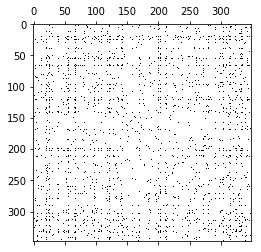

In [3]:
A_mat = list2matrix(A)
plt.figure()
plt.spy(A_mat)
plt.show()

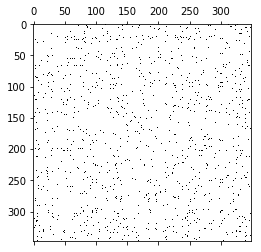

In [4]:
# generate the L matrix
L = localPageRank(A, c=0.85, return_only_neighbours=True)
L_mat = list2matrix(L)
plt.figure()
plt.spy(L_mat)
plt.show()

In [5]:
def getNeighsAvgDegree(node_list, degree):
    out = 0.
    for node in node_list:
        out += degree[node]
    if len(node_list) > 0:
        return out/len(node_list)
    else:
        return 0

In [6]:
def cluster_std(nodes, measure):
    clust_measure = measure[nodes]
    if clust_measure.shape[0] <= 1:
        return 0.
    return 1./clust_measure.std()

In [7]:
# get in/out degrees
inDeg, outDeg = getInOutDegree(L)

# get the ratio between the two
ratio = np.array(inDeg)/np.array(outDeg)
ratio[np.array(inDeg)<=1e-15] = 0
ratio[np.array(outDeg)<=1e-15] = 0

# and the average degree of the neighbours
avgNeighsInDeg = [0.]*N
avgNeighsOutDeg = [0.]*N

for i, edge_list in enumerate(A):
    node_list = [edge[0] for edge in edge_list]
    avgNeighsInDeg[i] = getNeighsAvgDegree(node_list, inDeg)
    avgNeighsOutDeg[i] = getNeighsAvgDegree(node_list, outDeg)
    
# compute ratio between in deg and average neighs in deg
ratio1 = np.array(inDeg)
ratio1[np.array(avgNeighsInDeg)==0] = 0
ratio1[np.array(avgNeighsInDeg)!=0] /= np.array(avgNeighsInDeg)[np.array(avgNeighsInDeg)!=0]
# do the same for the average neighs out deg
ratio2 = np.array(inDeg)
ratio2[np.array(avgNeighsOutDeg)==0] = 0
ratio2[np.array(avgNeighsOutDeg)!=0] /= np.array(avgNeighsOutDeg)[np.array(avgNeighsOutDeg)!=0]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


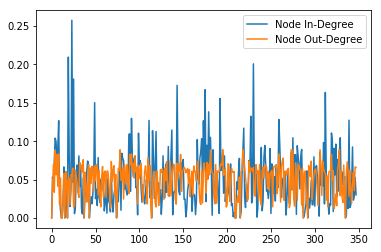

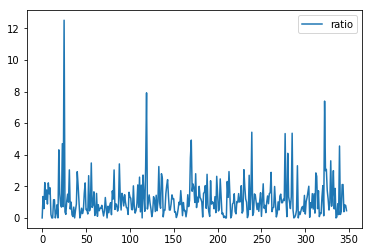

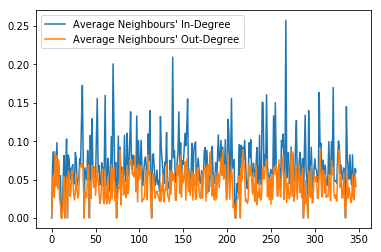

In [8]:
# plot the results
fig, ax = plt.subplots(1, 1)
ax.plot(inDeg)
ax.plot(outDeg)
ax.legend(["Node In-Degree", "Node Out-Degree"])
fig, ax = plt.subplots(1, 1)
ax.plot(ratio)
ax.legend(["ratio"])
fig, ax = plt.subplots(1, 1)
ax.plot(avgNeighsInDeg)
ax.plot(avgNeighsOutDeg)
ax.legend(["Average Neighbours' In-Degree", "Average Neighbours' Out-Degree"])

We start by assigning to each node a different cluster, we then merge the clusters of neighbouring nodes if the relevance measure of the cluster is higher after the merge.

In [9]:
# A and L are expected in edgelist form, measure is a numpy array
def cluster(A, L, measure):
    # node id 0->N-1
    clusters = np.arange(len(A), dtype=int)
    idxs = np.arange(len(A), dtype=int)
    link_to_follow = [[True for _ in node_list] for node_list in A]
    
    # initialize exit flag
    flag=True
    # while the exit flag is not False do
    while flag:
        flag = False
        old_clusts = np.array(clusters)
        # for each node
        for n, c in enumerate(clusters):
            # extract the current cluster
            curr_cluster = idxs[clusters==c]
            # follow the link that corresponds to it's maximum relevance
            weights = np.array([e[1] for e in L[n]])[link_to_follow[n]]
            if weights.shape[0] > 0:
                max_idx = np.argmax(weights)
                link_to_follow[n][max_idx] = False
                neigh = L[n][max_idx][0]
                # make sure that the nodes are in different clusters
                if c != clusters[neigh]:
                    neigh_cluster = idxs[clusters==clusters[neigh]]
                    merge = cluster_std(list(curr_cluster)+list(neigh_cluster), measure)
                    clust1 = cluster_std(list(curr_cluster), measure)
                    clust2 = cluster_std(list(neigh_cluster), measure)
                    if clust1==clust2==0:
                        split = 0
                    else:
                        split = 2*clust1*clust2/(clust1**2+clust2**2)
                    #print("node:", n, "merge:", merge, "split", split)
                    if merge > split:
                        clusters[neigh_cluster] = c

        
        flag = not np.all(clusters==old_clusts)
        
    return clusters

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


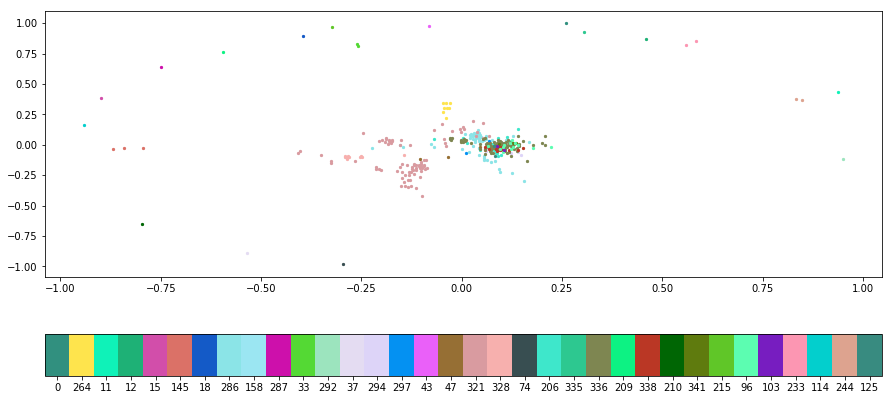

In [13]:
clusters = cluster(A, L, np.array(ratio))
_ = plotNetworkClusters(A_mat, list(clusters.astype(int)), 5, draw_edges=False)